# Setups

In [ ]:
from IPython.display import clear_output

!pip install datasets transformers rouge_score nltk
!pip install pyarrow
# !pip install -q sentencepiece
# !pip install rouge-score # google package version

clear_output()

In [ ]:
import os
import re
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

# nlp stuff
import nltk
nltk.download('punkt')

# tf stuff
import tensorflow_datasets as tfds 
import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration # pegasus
from transformers import BartTokenizer, TFBartForConditionalGeneration # bart

# pytorch dataset types
import datasets
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_metric, load_dataset

# pytorch bart stuff
import torch
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer

# Load data

Start by loading into pandas

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# data_path ="/content/gdrive/MyDrive/Classes/W266_NLP/w266_reddit_summarization/data/reddit_parquet/"
data_path ="/content/gdrive/MyDrive/w266/w266_reddit_summarization/data/reddit_parquet/"

Mounted at /content/gdrive


In [ ]:
os.chdir(data_path)
files = [i for i in os.listdir(data_path) if re.search("reddit_data", i)]

In [ ]:
files

['reddit_data_00.parquet',
 'reddit_data_01.parquet',
 'reddit_data_02.parquet',
 'reddit_data_03.parquet',
 'reddit_data_04.parquet',
 'reddit_data_05.parquet',
 'reddit_data_06.parquet',
 'reddit_data_07.parquet']

In [ ]:
%%time
df = pd.read_parquet(files)

CPU times: user 17.7 s, sys: 10.7 s, total: 28.4 s
Wall time: 28.7 s


In [ ]:
# df_copy = df.copy()
df = df_copy.copy()

Count vocab by lowercasing all words and splitting words on whitespace.

In [ ]:
%%time
def count_vocab(item):
  return len(set(item.lower().split(" ")))

def count_total_words(x):
  return len(x.lower().split(" "))

df['content_vocab'] = df['content'].map(count_vocab)
df['summary_vocab'] = df['summary'].map(count_vocab)

df['content_total_words'] = df['content'].map(count_total_words)
df['summary_total_words'] = df['summary'].map(count_total_words)

CPU times: user 3min 27s, sys: 1.55 s, total: 3min 29s
Wall time: 3min 28s


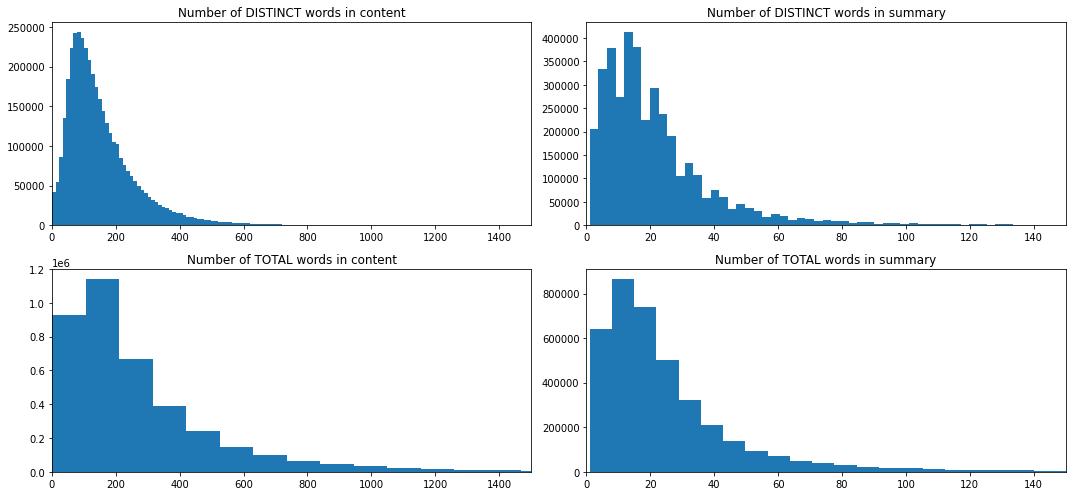

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15,7)) 

ax[0][0].hist(df['content_vocab'], bins=200)
ax[0][0].set_xlim(0, 1500)
ax[0][0].title.set_text("Number of DISTINCT words in content")

ax[0][1].hist(df['summary_vocab'], bins=500)
ax[0][1].set_xlim(0, 150)
ax[0][1].title.set_text("Number of DISTINCT words in summary")

# count total words
ax[1][0].hist(df['content_total_words'], bins=200)
ax[1][0].set_xlim(0, 1500)
ax[1][0].title.set_text("Number of TOTAL words in content")

ax[1][1].hist(df['summary_total_words'], bins=500)
ax[1][1].set_xlim(0, 150)
ax[1][1].title.set_text("Number of TOTAL words in summary")

fig.tight_layout()

In [ ]:
%%time
print("Starting number of rows: {}".format(df.shape[0]))

# some posts just have 1 word, or repeat the one word over and over and is not a real post. 
# only keep contents with at least 5 distinct words

df = df[df['content_vocab'] >= 10]
print("Rows after filtering content to have >= 10 distinct words: {}".format(df.shape[0]))

# do the same for summaries, want at least 2 distinct words
# df = df[df['summary'].map(lambda x: count_vocab(x) >= 2)]
df = df[df['summary_vocab'] >= 2]
print("Rows after filtering content to have >= 2 distinct words: {}".format(df.shape[0]))

# after observing distributions of word counts in EDA, deciding to keep...
# content with 20-1000 TOTAL words
# summaries with 2 - 100 TOTAL words
df = df[(df['content_total_words'] >= 20) & (df['content_total_words'] < 1001)]
print("Rows after filtering content to 20-1000 total words: {}".format(df.shape[0]))

df = df[(df['summary_total_words'] >= 2) & (df['summary_total_words'] < 101)]
print("Rows after filtering summaries to 2-100 total words: {}".format(df.shape[0]))

Starting number of rows: 3848330
Rows after filtering content to have >= 10 distinct words: 3818715
Rows after filtering content to have >= 2 distinct words: 3777540
Rows after filtering content to 20-1000 total words: 3642077
Rows after filtering summaries to 2-100 total words: 3550127
CPU times: user 1.62 s, sys: 26.9 ms, total: 1.65 s
Wall time: 1.61 s


In [ ]:
# df_copy = df.copy()
df = df_copy.copy()

Count vocab. This takes way too long. Find more efficient way. Just stopping after 50k obs. Starts to go super slow at 50k obs. 

In [ ]:
%%time
row_count = []
distinct_count = []
distinct_words = {'the'}

for i,x in enumerate(tqdm(df['content'])):
  x2 = set([re.sub('[^a-zA-Z]+', '', i) for i in x.lower().split(' ')])
  distinct_words = distinct_words | x2
  if i % 1000 == 0:
    row_count.append(i)
    distinct_count.append(len(distinct_words))
  if i > 50000:
    break

print(len(distinct_words))

  1%|▏         | 50001/3550127 [04:56<5:45:54, 168.64it/s]

146350
CPU times: user 4min 53s, sys: 6.1 s, total: 4min 59s
Wall time: 4min 56s


Distinct vocab just doesn't seem to plateau anytime soon

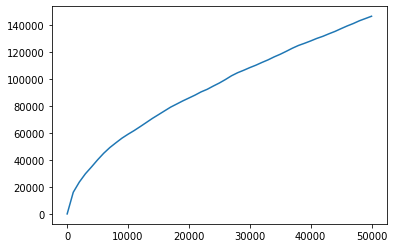

In [ ]:
plt.plot(row_count, distinct_count)
print("")

Count subreddit groupings

In [ ]:
df_subreddit = df['subreddit'].value_counts().reset_index().rename(columns={"index": "subreddit", "subreddit": "N"})
df_subreddit

,subreddit,N
0,AskReddit,557539
1,relationships,313511
2,leagueoflegends,101793
3,tifu,48751
4,trees,44899
...,...,...
28296,skilledtrades,1
28297,BoxModders,1
28298,AlphaCentauriCOC,1
28299,modifiedvapes,1
